In [21]:
import pandas as pd
import os

data_folder = "./data-premier-league/"

csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

processed_dfs = []

def clean_and_preprocess(df):
    df_cleaned = df.dropna()
    
    if 'FTR' in df_cleaned.columns:
        df_cleaned['FTR'] = df_cleaned['FTR'].map({'H': 1, 'A': -1, 'D': 0})
    
    # if 'Referee' in df_cleaned.columns:
    #     referee_mapping = {referee: idx for idx, referee in enumerate(df_cleaned['Referee'].unique())}
    #     df_cleaned['Referee'] = df_cleaned['Referee'].map(referee_mapping)
    
    numerical_features = ['HS', 'AS', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
    existing_features = [feature for feature in numerical_features if feature in df_cleaned.columns]
    df_cleaned[existing_features] = df_cleaned[existing_features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    if 'HF' in df_cleaned.columns and 'AF' in df_cleaned.columns:
        df_cleaned['FD'] = df_cleaned['HF'] - df_cleaned['AF']
    
    if 'HY' in df_cleaned.columns and 'HR' in df_cleaned.columns and 'AY' in df_cleaned.columns and 'AR' in df_cleaned.columns:
        df_cleaned['CD'] = (df_cleaned['HY'] + df_cleaned['HR']) - (df_cleaned['AY'] + df_cleaned['AR'])
    
    if {'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HS', 'AS'}.issubset(df_cleaned.columns):
        df_cleaned['RefereeDecisionRate'] = (df_cleaned['HF'] + df_cleaned['AF'] + df_cleaned['HY'] +
                                             df_cleaned['AY'] + df_cleaned['HR'] + df_cleaned['AR']) / \
                                            (df_cleaned['HS'] + df_cleaned['AS'])
    return df_cleaned

for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    processed_df = clean_and_preprocess(df)
    processed_dfs.append(processed_df)

# for i, df in enumerate(processed_dfs):
#     output_file = os.path.join(data_folder, f"processed_{csv_files[i]}")
#     df.to_csv(output_file, index=False)

print(f"Processed {len(processed_dfs)} datasets.")

Processed 24 datasets.


In [22]:
print(processed_dfs[0].head)

<bound method NDFrame.head of          Date        HomeTeam          AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  \
0    09/08/19       Liverpool           Norwich     4     1    1     4     0   
1    10/08/19        West Ham          Man City     0     5   -1     0     1   
2    10/08/19     Bournemouth  Sheffield United     1     1    0     0     0   
3    10/08/19         Burnley       Southampton     3     0    1     0     0   
4    10/08/19  Crystal Palace           Everton     0     0    0     0     0   
..        ...             ...               ...   ...   ...  ...   ...   ...   
375  26/07/20       Leicester        Man United     0     2   -1     0     0   
376  26/07/20        Man City           Norwich     5     0    1     2     0   
377  26/07/20       Newcastle         Liverpool     1     3   -1     1     1   
378  26/07/20     Southampton  Sheffield United     3     1    1     0     1   
379  26/07/20        West Ham       Aston Villa     1     1    0     0     0   

    HTR  

In [23]:
# import numpy as np
# from scipy.optimize import minimize
# import pandas as pd

# # Combine the first 15 dataframes as training data
# training_data = pd.concat(processed_dfs[:15], ignore_index=True)

# # Combine the remaining dataframes as testing data
# testing_data = pd.concat(processed_dfs[16:21], ignore_index=True)

# # Extract unique teams and referees
# teams = training_data['HomeTeam'].unique()
# referees = training_data['Referee'].unique()

# # Initialize mappings for teams and referees
# team_to_idx = {team: i for i, team in enumerate(teams)}
# referee_to_idx = {ref: i for i, ref in enumerate(referees)}

# # Features to include in the optimization
# feature_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HC', 'AC']
# training_data = training_data.dropna(subset=feature_cols)
# testing_data = testing_data.dropna(subset=feature_cols)

# # Normalize features
# for col in feature_cols:
#     max_val = training_data[col].max()
#     if max_val > 0:
#         training_data[col] /= max_val
#         testing_data[col] /= max_val

# # Initialize parameters for optimization
# n_teams = len(teams)
# n_referees = len(referees)
# n_features = len(feature_cols)

# # Initialize with small random values
# initial_weights = np.random.rand(n_features) * 0.1
# initial_bias = np.concatenate([
#     np.random.rand(n_teams) * 0.1,  # Team biases
#     np.random.rand(n_referees) * 0.1,  # Referee biases
#     initial_weights  # Feature weights
# ])

# # Loss function
# def objective_function(bias, training_data, team_to_idx, referee_to_idx, lambda_team=1e-6, lambda_ref=1e-6, lambda_feat=1e-6):
#     # Extract parameters
#     team_bias = bias[:n_teams]
#     referee_bias = bias[n_teams:n_teams + n_referees]
#     feature_weights = bias[n_teams + n_referees:]

#     # Compute feature contribution
#     feature_diffs = training_data[feature_cols].copy()
#     for col in ['AS', 'AST', 'AF', 'AY', 'AR', 'AC']:  # Reverse for away features
#         feature_diffs[col] = -feature_diffs[col]
#     feature_contribution = feature_diffs.values @ feature_weights

#     # Compute game biases
#     game_bias = (
#         training_data['HomeTeam'].map(lambda x: team_bias[team_to_idx[x]]) -
#         training_data['AwayTeam'].map(lambda x: team_bias[team_to_idx[x]]) +
#         training_data['Referee'].map(lambda x: referee_bias[referee_to_idx[x]]) +
#         feature_contribution
#     )
    
#     # Loss: Minimize game bias squared
#     loss_game = np.sum(game_bias ** 2)
    
#     # Regularization: Penalize extreme bias and feature weight values
#     loss_reg = (
#         lambda_team * np.sum(team_bias ** 2) +
#         lambda_ref * np.sum(referee_bias ** 2) +
#         lambda_feat * np.sum(feature_weights ** 2)
#     )
    
#     return loss_game + loss_reg

# # Optimization
# result = minimize(
#     fun=objective_function,
#     x0=initial_bias,
#     args=(training_data, team_to_idx, referee_to_idx),
#     method='L-BFGS-B',
#     options={'disp': True}
# )

# # Extract optimized parameters
# optimized_team_bias = result.x[:n_teams]
# optimized_referee_bias = result.x[n_teams:n_teams + n_referees]
# optimized_feature_weights = result.x[n_teams + n_referees:]

# # Map results back to teams, referees, and features
# team_bias_result = {team: bias for team, bias in zip(teams, optimized_team_bias)}
# referee_bias_result = {ref: bias for ref, bias in zip(referees, optimized_referee_bias)}
# feature_weights_result = dict(zip(feature_cols, optimized_feature_weights))

# # --- Testing Phase ---
# # Evaluate on test data
# test_feature_diffs = testing_data[feature_cols].copy()
# for col in ['AS', 'AST', 'AF', 'AY', 'AR', 'AC']:
#     test_feature_diffs[col] = -test_feature_diffs[col]
# test_feature_contribution = test_feature_diffs.values @ optimized_feature_weights

# test_game_bias = (
#     testing_data['HomeTeam'].map(lambda x: team_bias_result.get(x, 0)) -
#     testing_data['AwayTeam'].map(lambda x: team_bias_result.get(x, 0)) +
#     testing_data['Referee'].map(lambda x: referee_bias_result.get(x, 0)) +
#     test_feature_contribution
# )

# # Calculate test loss
# test_loss = np.mean(test_game_bias ** 2)
# avg_game_bias = np.mean(test_game_bias)

# # Display results
# print("Optimized Team Biases (Home Advantage):", team_bias_result)
# print("Optimized Referee Biases:", referee_bias_result)
# print("Optimized Feature Weights:", feature_weights_result)
# print("Test Loss (Mean Squared Game Bias):", test_loss)

# print("Mean Game Bias", avg_game_bias)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import pandas as pd

# Combine the first 15 dataframes as training data
training_data = pd.concat(processed_dfs[:15], ignore_index=True)

# Combine the remaining dataframes as testing data
testing_data = pd.concat(processed_dfs[16:21], ignore_index=True)

# Extract unique teams and referees
teams = training_data['HomeTeam'].unique()
referees = training_data['Referee'].unique()

# Initialize mappings for teams and referees
team_to_idx = {team: i for i, team in enumerate(teams)}
referee_to_idx = {ref: i for i, ref in enumerate(referees)}

# Features to include in the optimization
feature_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'HC', 'AC']
training_data = training_data.dropna(subset=feature_cols)
testing_data = testing_data.dropna(subset=feature_cols)

# Normalize features
for col in feature_cols:
    max_val = training_data[col].max()
    if max_val > 0:
        training_data[col] /= max_val
        testing_data[col] /= max_val

# Initialize parameters for optimization
n_teams = len(teams)
n_referees = len(referees)
n_features = len(feature_cols)

# Initialize with small random values
initial_weights = np.random.rand(n_features) * 0.1
initial_bias = np.concatenate([
    np.random.rand(n_teams) * 0.1,  # Team biases
    np.random.rand(n_referees) * 0.1,  # Referee biases
    initial_weights  # Feature weights
])

# To log values at each iteration
log = {'objective': [], 'team_bias': [], 'referee_bias': [], 'feature_weights': []}

# Loss function
def objective_function(bias, training_data, team_to_idx, referee_to_idx, lambda_team=1e-6, lambda_ref=1e-6, lambda_feat=1e-6):
    # Extract parameters
    team_bias = bias[:n_teams]
    referee_bias = bias[n_teams:n_teams + n_referees]
    feature_weights = bias[n_teams + n_referees:]

    # Log current values
    log['objective'].append(None)  # Placeholder, updated in minimize
    log['team_bias'].append(team_bias.copy())
    log['referee_bias'].append(referee_bias.copy())
    log['feature_weights'].append(feature_weights.copy())

    # Compute feature contribution
    feature_diffs = training_data[feature_cols].copy()
    for col in ['AS', 'AST', 'AF', 'AY', 'AR', 'AC']:  # Reverse for away features
        feature_diffs[col] = -feature_diffs[col]
    feature_contribution = feature_diffs.values @ feature_weights

    # Compute game biases
    game_bias = (
        training_data['HomeTeam'].map(lambda x: team_bias[team_to_idx[x]]) -
        training_data['AwayTeam'].map(lambda x: team_bias[team_to_idx[x]]) +
        training_data['Referee'].map(lambda x: referee_bias[referee_to_idx[x]]) +
        feature_contribution
    )
    
    # Loss: Minimize game bias squared
    loss_game = np.sum(game_bias ** 2)
    
    # Regularization: Penalize extreme bias and feature weight values
    loss_reg = (
        lambda_team * np.sum(team_bias ** 2) +
        lambda_ref * np.sum(referee_bias ** 2) +
        lambda_feat * np.sum(feature_weights ** 2)
    )
    
    return loss_game + loss_reg

# Callback function to log objective values
def callback(bias):
    log['objective'][-1] = objective_function(bias, training_data, team_to_idx, referee_to_idx)

# Optimization
result = minimize(
    fun=objective_function,
    x0=initial_bias,
    args=(training_data, team_to_idx, referee_to_idx),
    method='L-BFGS-B',
    options={'disp': True},
    callback=callback
)





RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36017D+01    |proj g|=  3.29661D+02


 This problem is unconstrained.



At iterate    1    f=  2.59551D+01    |proj g|=  7.00029D+01

At iterate    2    f=  1.29568D+01    |proj g|=  3.67488D+01

At iterate    3    f=  3.53588D+00    |proj g|=  1.54775D+01

At iterate    4    f=  1.75260D+00    |proj g|=  8.51117D+00

At iterate    5    f=  7.32108D-01    |proj g|=  3.34395D+00

At iterate    6    f=  5.15470D-01    |proj g|=  3.14055D+00

At iterate    7    f=  4.11511D-01    |proj g|=  2.86433D+00

At iterate    8    f=  3.58902D-01    |proj g|=  9.76663D-01

At iterate    9    f=  3.21005D-01    |proj g|=  1.01641D+00

At iterate   10    f=  2.77384D-01    |proj g|=  1.21547D+00

At iterate   11    f=  2.59063D-01    |proj g|=  4.90359D+00

At iterate   12    f=  2.19739D-01    |proj g|=  8.60389D-01

At iterate   13    f=  2.05568D-01    |proj g|=  7.40120D-01

At iterate   14    f=  1.82199D-01    |proj g|=  1.51090D+00

At iterate   15    f=  1.78827D-01    |proj g|=  3.07006D+00

At iterate   16    f=  1.57139D-01    |proj g|=  1.38247D+00

At iter

In [25]:
# Extract optimized parameters
optimized_team_bias = result.x[:n_teams]
optimized_referee_bias = result.x[n_teams:n_teams + n_referees]
optimized_feature_weights = result.x[n_teams + n_referees:]

# Map results back to teams, referees, and features
team_bias_result = {team: bias for team, bias in zip(teams, optimized_team_bias)}
referee_bias_result = {ref: bias for ref, bias in zip(referees, optimized_referee_bias)}
feature_weights_result = dict(zip(feature_cols, optimized_feature_weights))

# --- Testing Phase ---
# Evaluate on test data
test_feature_diffs = testing_data[feature_cols].copy()
for col in ['AS', 'AST', 'AF', 'AY', 'AR', 'AC']:
    test_feature_diffs[col] = -test_feature_diffs[col]
test_feature_contribution = test_feature_diffs.values @ optimized_feature_weights

test_game_bias = (
    testing_data['HomeTeam'].map(lambda x: team_bias_result.get(x, 0)) -
    testing_data['AwayTeam'].map(lambda x: team_bias_result.get(x, 0)) +
    testing_data['Referee'].map(lambda x: referee_bias_result.get(x, 0)) +
    test_feature_contribution
)

# Calculate mean game bias
avg_game_bias = np.mean(test_game_bias)

# Print results
print("Optimized Team Biases (Home Advantage):", team_bias_result)
print("\nOptimized Referee Biases:", referee_bias_result)
print("\nOptimized Feature Weights:", feature_weights_result)
print("\nMean Game Bias:", avg_game_bias)

Optimized Team Biases (Home Advantage): {'Liverpool': 0.044447945892526354, 'West Ham': 0.044452867722176985, 'Bournemouth': 0.04445381900289292, 'Burnley': 0.044451240798909844, 'Crystal Palace': 0.044445610456328014, 'Watford': 0.044448757914879414, 'Tottenham': 0.044451441873124296, 'Leicester': 0.04445348063840582, 'Newcastle': 0.044454619603190824, 'Man United': 0.04445004934893744, 'Arsenal': 0.044452230905127205, 'Aston Villa': 0.04444958021737502, 'Brighton': 0.044465374430546885, 'Everton': 0.04445025532995976, 'Norwich': 0.044450753038280465, 'Southampton': 0.044451099473271215, 'Man City': 0.044448720559722855, 'Sheffield United': 0.04447664750619441, 'Chelsea': 0.04445022030560593, 'Wolves': 0.044449930592410744, 'Sunderland': 0.04444871621135779, 'Swansea': 0.044457433394196194, 'West Brom': 0.04444902721623094, 'Fulham': 0.04445229345896448, 'Hull': 0.0444561906273926, 'Stoke': 0.0444488920747677, 'Cardiff': 0.04443673228535457, 'Blackburn': 0.044441277020444356, 'QPR': 0

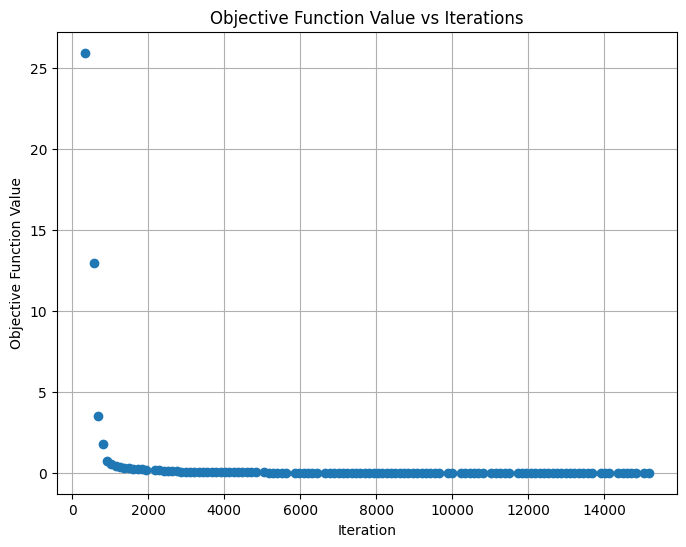

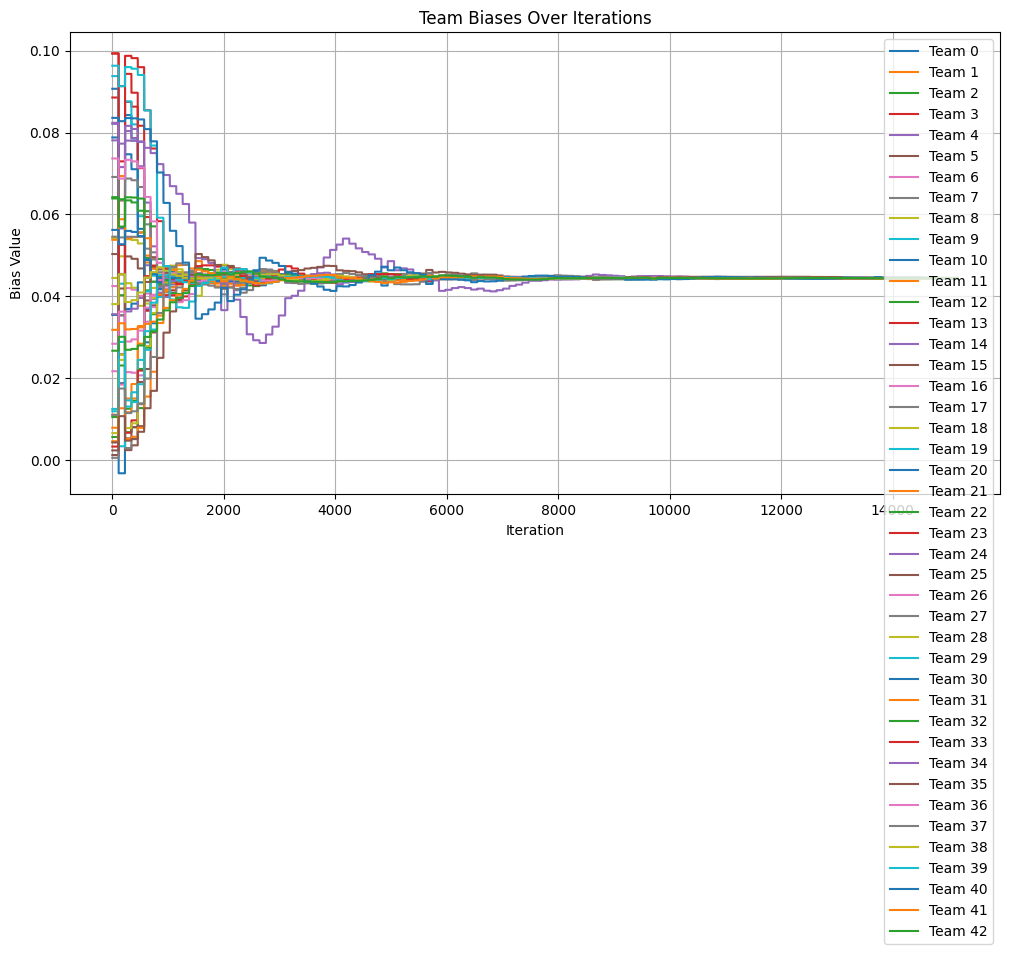

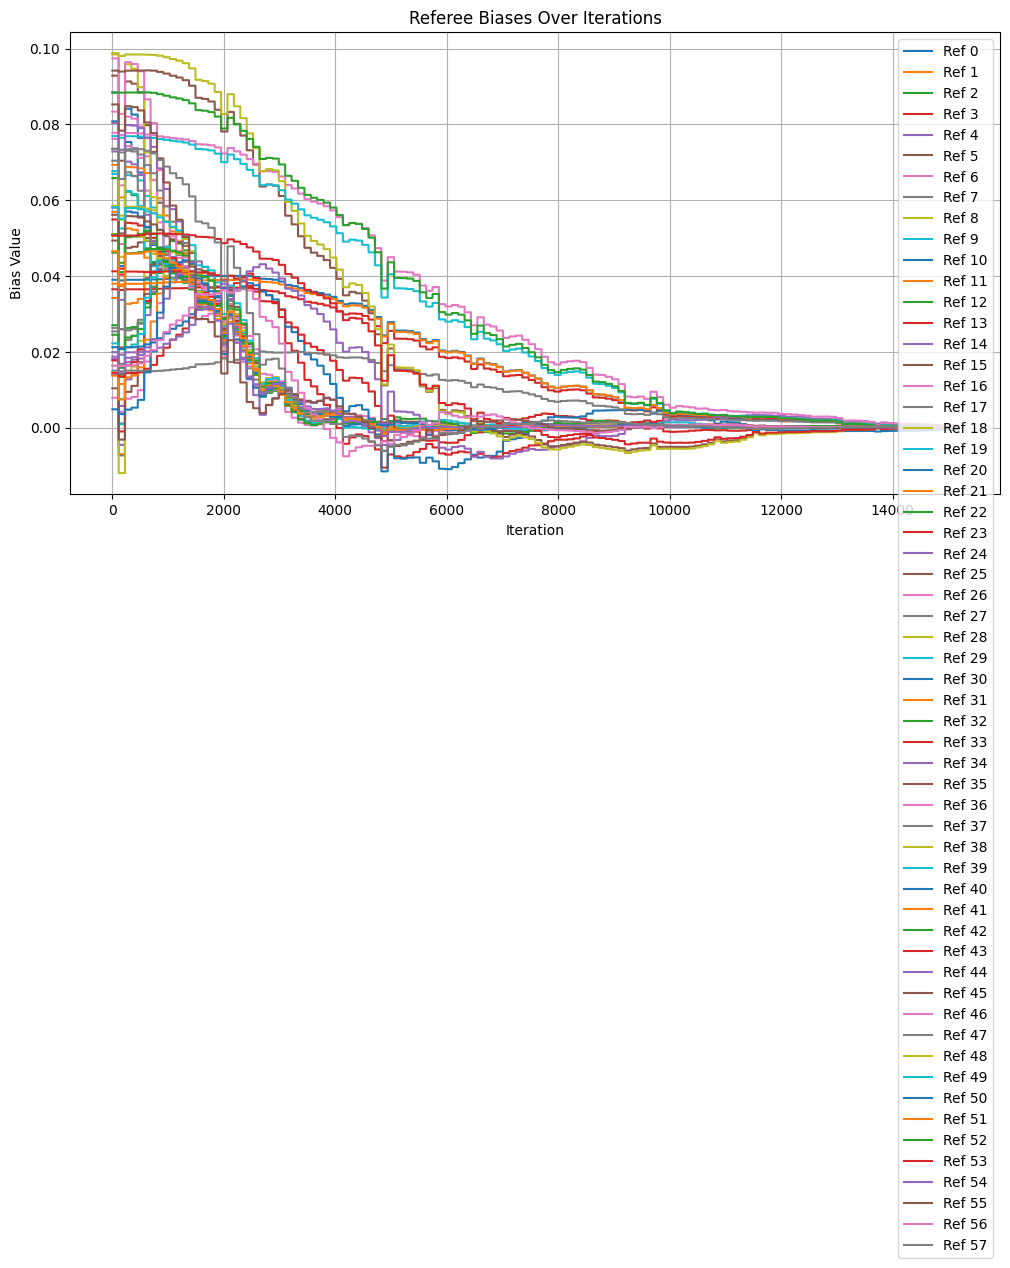

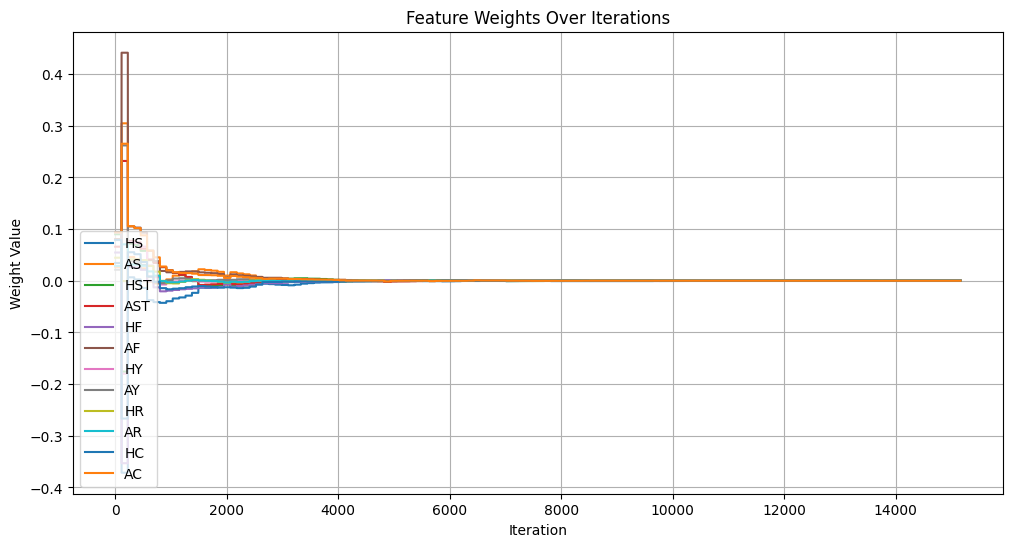

In [26]:
# Visualization of iterations
iterations = range(len(log['objective']))
plt.figure(figsize=(8, 6))
plt.plot(iterations, log['objective'], marker='o')
plt.title('Objective Function Value vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.grid()
plt.show()

# Plot team biases
plt.figure(figsize=(12, 6))
for team_idx in range(n_teams):
    team_values = [log['team_bias'][i][team_idx] for i in iterations]
    plt.plot(iterations, team_values, label=f'Team {team_idx}')
plt.title('Team Biases Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Bias Value')
plt.legend()
plt.grid()
plt.show()

# Plot referee biases
plt.figure(figsize=(12, 6))
for ref_idx in range(n_referees):
    ref_values = [log['referee_bias'][i][ref_idx] for i in iterations]
    plt.plot(iterations, ref_values, label=f'Ref {ref_idx}')
plt.title('Referee Biases Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Bias Value')
plt.legend()
plt.grid()
plt.show()

# Plot feature weights
plt.figure(figsize=(12, 6))
for feat_idx, feat in enumerate(feature_cols):
    feat_values = [log['feature_weights'][i][feat_idx] for i in iterations]
    plt.plot(iterations, feat_values, label=feat)
plt.title('Feature Weights Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Weight Value')
plt.legend()
plt.grid()
plt.show()

In [27]:
# Ensure processed_dfs, team_bias_result, and referee_bias_result are defined
import numpy as np
import pandas as pd

# Initialize variables for missing teams/referees
average_team_bias = np.mean(list(team_bias_result.values()))
#average_team_bias = np.mean(list(team_bias_result.values()))

average_referee_bias = np.mean(list(referee_bias_result.values()))
#average_referee_bias = np.mean(list(referee_bias_result.values()))


evaluation_results = []

# Iterate through 21st to 24th dataframes
for i in range(20, 24):
    evaluation_data = processed_dfs[i].copy()
    
    # Fill missing team and referee biases with the average values
    evaluation_data['HomeTeamBias'] = evaluation_data['HomeTeam'].map(lambda x: team_bias_result.get(x, average_team_bias))
    evaluation_data['AwayTeamBias'] = evaluation_data['AwayTeam'].map(lambda x: team_bias_result.get(x, average_team_bias))
    evaluation_data['RefereeBias'] = evaluation_data['Referee'].map(lambda x: referee_bias_result.get(x, average_referee_bias))
    
    # Calculate game bias for each match
    evaluation_data['GameBias'] = (
        evaluation_data['HomeTeamBias'] -
        evaluation_data['AwayTeamBias'] +
        evaluation_data['RefereeBias']
    )
    
    # Calculate the average game bias for the current dataframe
    average_game_bias = evaluation_data['GameBias'].mean()
    evaluation_results.append({'DataFrameIndex': i + 1, 'AverageGameBias': average_game_bias})
    
    # Save evaluation data for inspection
    print(f"DataFrame {i + 1} - Average Game Bias: {average_game_bias}")
    print(evaluation_data[['HomeTeam', 'AwayTeam', 'Referee', 'GameBias']].head())

# Print the results
print("Evaluation Results:", evaluation_results)

DataFrame 21 - Average Game Bias: 5.325197912801813e-05
     HomeTeam     AwayTeam     Referee  GameBias
0     Arsenal  Aston Villa      G Poll  0.000076
1      Bolton    Tottenham      P Dowd  0.000013
2     Everton      Watford    P Walton  0.000040
3   Newcastle        Wigan  M Atkinson  0.000040
4  Portsmouth    Blackburn     A Wiley  0.000100
DataFrame 22 - Average Game Bias: 5.763169355438946e-05
        HomeTeam     AwayTeam    Referee  GameBias
0    Aston Villa  Southampton   U Rennie  0.000268
1      Blackburn    West Brom      C Foy  0.000031
2         Bolton     Charlton     P Dowd  0.000015
3       Man City       Fulham  M Messias  0.000070
4  Middlesbrough    Newcastle  S Bennett -0.000035
DataFrame 23 - Average Game Bias: 4.595097263231323e-05
        HomeTeam   AwayTeam     Referee  GameBias
0        Arsenal  West Brom      H Webb  0.000038
1         Bolton      Stoke       C Foy  0.000014
2        Everton  Blackburn  A Marriner  0.000045
3           Hull     Fulham    P